## Exercise 1: Early stopping

1. Download the IRIS dataset using the method `sklearn.dataset.load_iris`. The
   `load_iris` method returns a dictionary with the following keys: `data` which
   contains a matrix with the sepal and petal lengths and widths,
   `feature_names` with the corresponding list of strings for the data names, `target` the corresponding flower label id, `target_names` the list of strings for the flower names.
2. Load data in a pandas DataFrame. This should include the `data` values and
   the flower `label`. Print the DataFrame to screen. *(Optional)* Inspect the data with e.g. correlation/scatter plots.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

2025-04-17 22:59:35.387763: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 22:59:35.390683: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 22:59:35.397950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744923575.409900   57281 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744923575.413328   57281 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 22:59:35.426786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Initial Iris DataFrame:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

    label  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


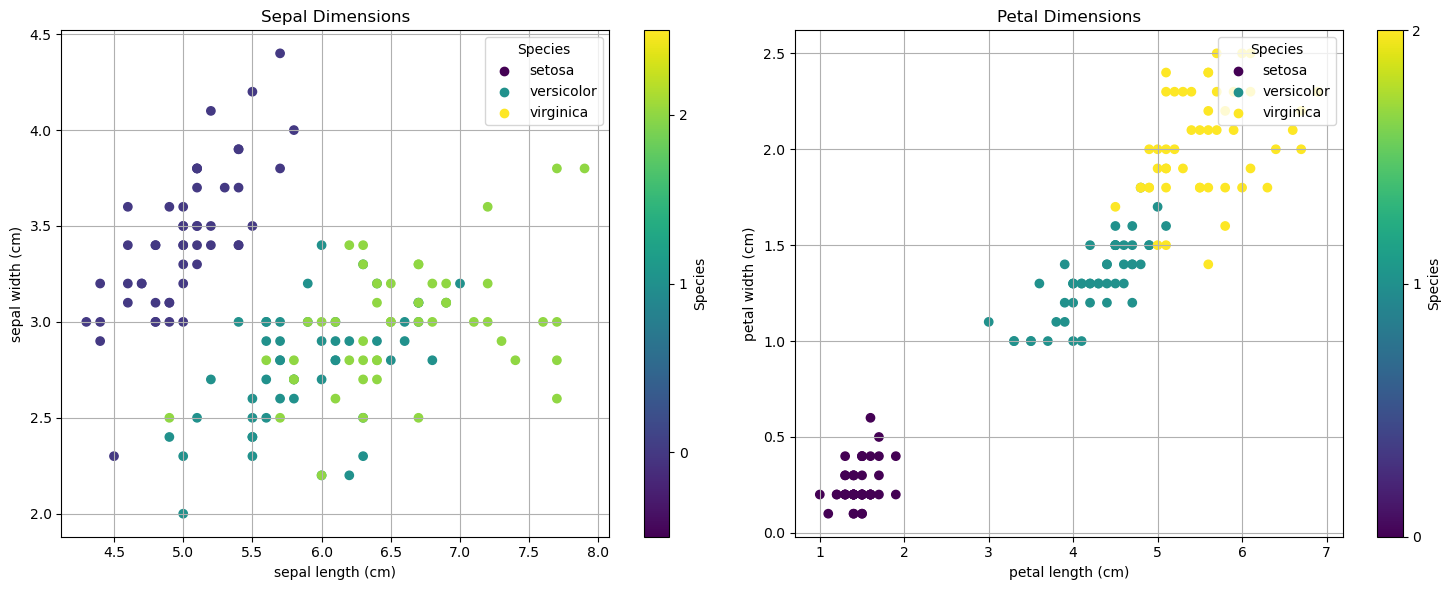

In [2]:
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['label'] = pd.Categorical.from_codes(iris.target, iris.target_names) # Add target names as a column

print("Initial Iris DataFrame:")
print(df.head())

plt.figure(figsize=(15, 6))
legend_colors = plt.cm.viridis(np.linspace(0, 1, len(iris.target_names)))

# First subplot
plt.subplot(1, 2, 1)
sc1 = plt.scatter(df.iloc[:, 0], df.iloc[:, 1], c=iris.target, cmap='viridis')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.title("Sepal Dimensions")
plt.colorbar(sc1, ticks=[0, 1, 2], label='Species')
plt.clim(-0.5, 2.5)

# Create legend with correct color parameter
for i, species in enumerate(iris.target_names):
    plt.scatter([], [], color=legend_colors[i], label=species)
plt.legend(title='Species', loc='upper right')
plt.grid()

# Second subplot
plt.subplot(1, 2, 2)
sc2 = plt.scatter(df.iloc[:, 2], df.iloc[:, 3], c=iris.target, cmap='viridis')
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3])
plt.title("Petal Dimensions")
plt.colorbar(sc2, ticks=[0, 1, 2], label='Species')


for i, species in enumerate(iris.target_names):
    plt.scatter([], [], color=legend_colors[i], label=species)
plt.legend(title='Species', loc='upper right')
plt.grid()

plt.tight_layout()
plt.show()

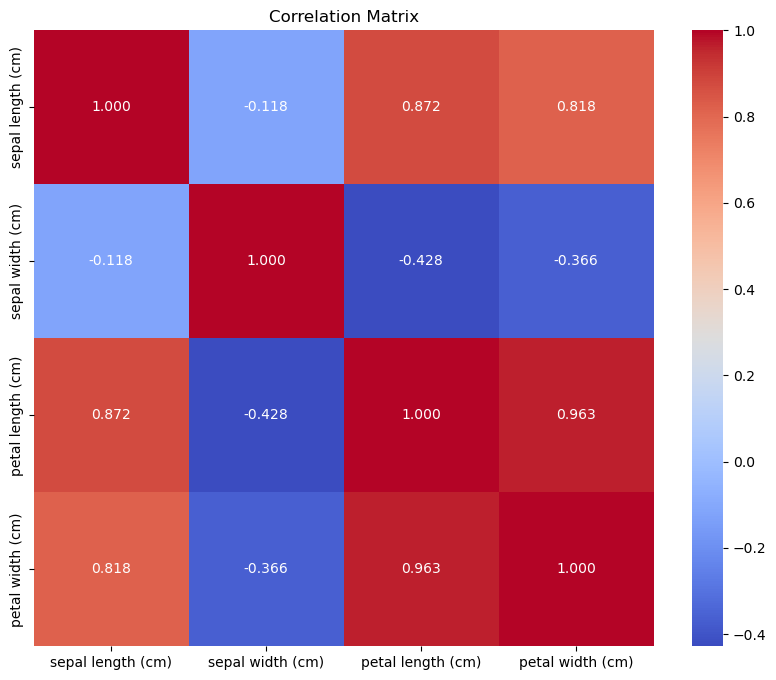

In [3]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

3. Given that the `label` column is a categorical feature, we should convert it
   to a one-hot encoding. Perform this one-hot encoding operation by replacing the `label` column with three new columns: `label_setosa`, `label_versicolor`, `label_virginica`.


In [4]:
# We want to replace the single 'label' column with three columns:
# "label_setosa", "label_versicolor", "label_virginica".
# We can do this using pandas.get_dummies.
df_dummies = pd.get_dummies(df['label'], prefix='label')

# Remove the original label column and concatenate the one-hot columns.
df = df.drop('label', axis=1)
df = pd.concat([df, df_dummies], axis=1)

print("\nDataFrame after one-hot encoding:")
print(df.head())


DataFrame after one-hot encoding:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   label_setosa  label_versicolor  label_virginica  
0          True             False            False  
1          True             False            False  
2          True             False            False  
3          True             False            False  
4          True             False            False  


4. Extract 80% of the data for training and keep 20% for test, using the
   `DataFrame.sample` method.

In [5]:
# Extract 80% of the data for training and reserve 20% for testing.
# We set a random_state for reproducibility.
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

print("\nShapes of the datasets:")
print("Training set:", train_df.shape)
print("Test set:", test_df.shape)

# Separate feature columns and label columns.
feature_cols = iris.feature_names           # The four measurements
label_cols = list(df_dummies.columns)         # The one-hot encoded columns

X_train = train_df[feature_cols].values
y_train = train_df[label_cols].values

X_test = test_df[feature_cols].values
y_test = test_df[label_cols].values


Shapes of the datasets:
Training set: (120, 7)
Test set: (30, 7)


5. Define a sequential model with 3 output nodes with `softmax` activation
   function. Perform a fit using Adam and the categorical cross-entropy loss
   function for 200 epochs, validation split of 40% and batch size of 32. Plot the learning curves (loss vs epochs) for the training and validation datasets.

2025-04-17 22:59:43.086201: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Training the model without early stopping...


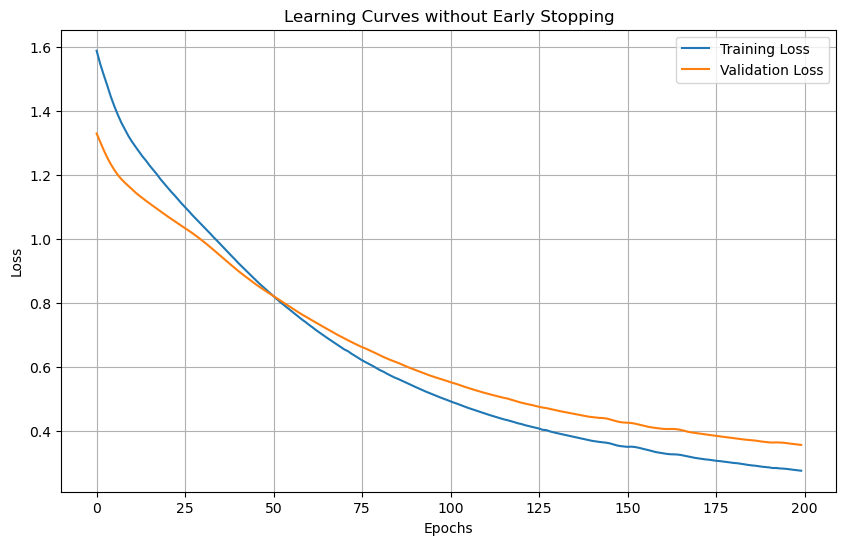

In [6]:
# Define a simple sequential model with a hidden layer and an output layer with 3 nodes.
model = Sequential([
    tf.keras.layers.Input(shape=(len(feature_cols),)),
    Dense(10, activation="relu"),
    Dense(3, activation="softmax")  # 3 output nodes for 3 classes
])

# Compile the model with Adam optimizer and categorical cross-entropy loss.
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

print("\nTraining the model without early stopping...")
history = model.fit(X_train, y_train,
                    epochs=200,
                    validation_split=0.4,
                    batch_size=32,
                    verbose=0)  # Set verbose to 0 for a clean output

# Plot the learning curves (loss vs epochs)
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Learning Curves without Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()


6. Modify the previous point in order to use early stopping on the validation
   loss with patience=10. Plot the learning curves and check the stopping epoch.

In [7]:
# Create a fresh model instance (we repeat the same architecture)
model_es = Sequential([
    tf.keras.layers.Input(shape=(len(feature_cols),)),
    Dense(10, activation="relu"),
    Dense(3, activation="softmax")
])
model_es.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Set up the EarlyStopping callback: monitor the validation loss with a patience of 10 epochs.
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

print("\nTraining the model with early stopping...")
history_es = model_es.fit(X_train, y_train,
                          epochs=200,
                          validation_split=0.4,
                          batch_size=32,
                          callbacks=[early_stop],
                          verbose=0)

# The training stops when early stopping is triggered.
print("Training stopped after", len(history_es.history["loss"]), "epochs.")


Training the model with early stopping...
Training stopped after 200 epochs.


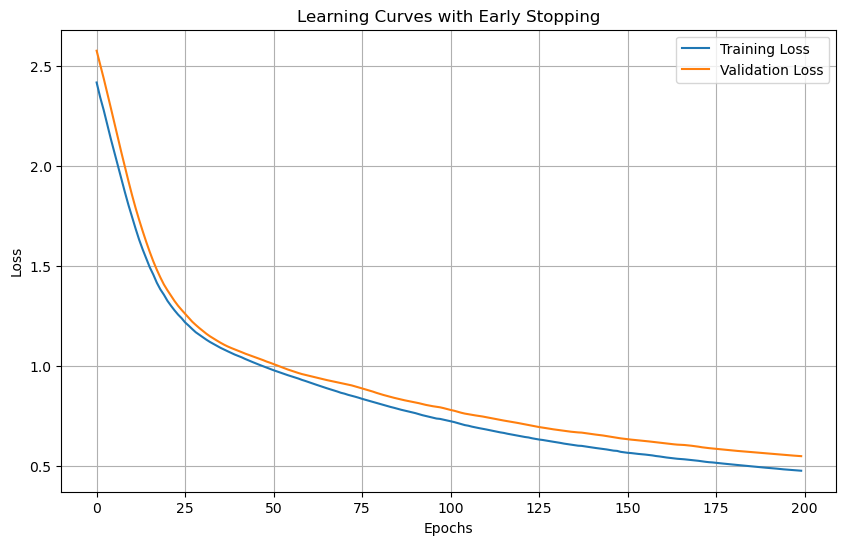

In [8]:
# Plot the learning curves with early stopping
plt.figure(figsize=(10, 6))
plt.plot(history_es.history["loss"], label="Training Loss")
plt.plot(history_es.history["val_loss"], label="Validation Loss")
plt.title("Learning Curves with Early Stopping")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

7. *(Optional)* Include the TensorBoard callback. Integrate the hyperopt
   pipeline implemented in the previous lecture using a `loss` the accuracy on
   the test set obtained in point 4.

In [9]:
# To use TensorBoard, first create a log directory with a timestamp.
# Uncomment the following lines if you want to run TensorBoard.
#
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the model with TensorBoard logging
history_tb = model.fit(X_train, y_train,
                       epochs=200,
                       validation_split=0.4,
                       batch_size=32,
                       callbacks=[tensorboard_callback],
                       verbose=0)
print("TensorBoard logs saved to:", log_dir)
#
# For integrating a hyperopt pipeline, you would typically define an objective function that:
#   - Builds a model given a set of hyperparameters,
#   - Trains the model,
#   - Evaluates its performance (e.g., using test accuracy or loss),
#   - And returns the metric you want to minimize (or maximize, with an appropriate transformation).
#
# The hyperopt package can then be used to search over the hyperparameter space to find the best settings.
# This integration is beyond the scope of this example but generally involves the following steps:
#   1. Define a search space.
#   2. Write an objective function that returns the loss or negative accuracy.
#   3. Use hyperopt.fmin to minimize the objective.
#
# Note: Make sure that your environment supports TensorBoard if you plan to use it.

TensorBoard logs saved to: logs/fit/20250417-230024


## Exercise 2: Forecasting time series

1. We provide numpy arrays for daily measurements performed in blocks of 10
   days. The data was already filtered and normalized. Download the following
   datasets and check the corresponding sizes:
    ```bash
    # for the training set
    wget https://raw.githubusercontent.com/scarrazza/DL2025/main/Lecture_6/training_data.npy
    wget https://raw.githubusercontent.com/scarrazza/DL2025/main/Lecture_6/training_label.npy
    # for the test set
    wget https://raw.githubusercontent.com/scarrazza/DL2025/main/Lecture_6/test_data.npy
    wget https://raw.githubusercontent.com/scarrazza/DL2025/main/Lecture_6/test_label.npy
    ```

In [16]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Load the data
train_data = np.load('training_data.npy')
train_labels = np.load('training_label.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_label.npy')


# Reshape the data for LSTM
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))

# Check the shapes of the datasets
print("Train Data Shape:", train_data.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

# Check data
print("Train Data Sample:", train_data[0])
print("Train Labels Sample:", train_labels[0])
print("Test Data Sample:", test_data[0])
print("Test Labels Sample:", test_labels[0])

Train Data Shape: (1490, 10, 1)
Train Labels Shape: (1490, 1)
Test Data Shape: (490, 10, 1)
Test Labels Shape: (490, 1)
Train Data Sample: [[0.12626189]
 [0.15069283]
 [0.18454275]
 [0.23283088]
 [0.29164864]
 [0.32804077]
 [0.32502262]
 [0.29258213]
 [0.25528242]
 [0.24196327]]
Train Labels Sample: [0.26495052]
Test Data Sample: [[0.15319113]
 [0.10411559]
 [0.0990554 ]
 [0.13897199]
 [0.21443391]
 [0.30698861]
 [0.39200977]
 [0.44845186]
 [0.4675604 ]
 [0.46343225]]
Test Labels Sample: [0.46164765]


2. Build and train an LSTM model using Adam with MSE loss, 25 epochs, batch size
   32. Print the final MSE for the test set.

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(train_data.shape[1], train_data.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
model.fit(train_data, train_labels, epochs=25, batch_size=32, verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate(test_data, test_labels)
print(f"Test Loss (MSE): {test_loss}")

# Make predictions
test_predictions = model.predict(test_data)

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1043  
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0086
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0081
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0080
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 9/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064
Epoch 10/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063
Epoch 11/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0056
Epoch 12/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0053
Epoch 13/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 14/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 15/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 16/25
47/47

3. Plot the following quantities: training and test data vs days, the LSTM
   predictions for the test data, the LSTM predictions for the first 100 days,
   the residual (y_test - prediction), and the scatter plot between the true
   test data vs predictions.

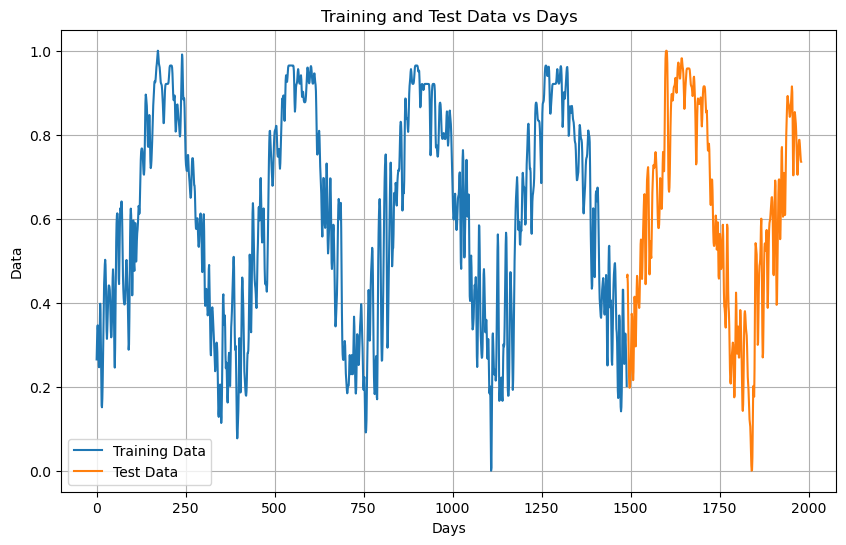

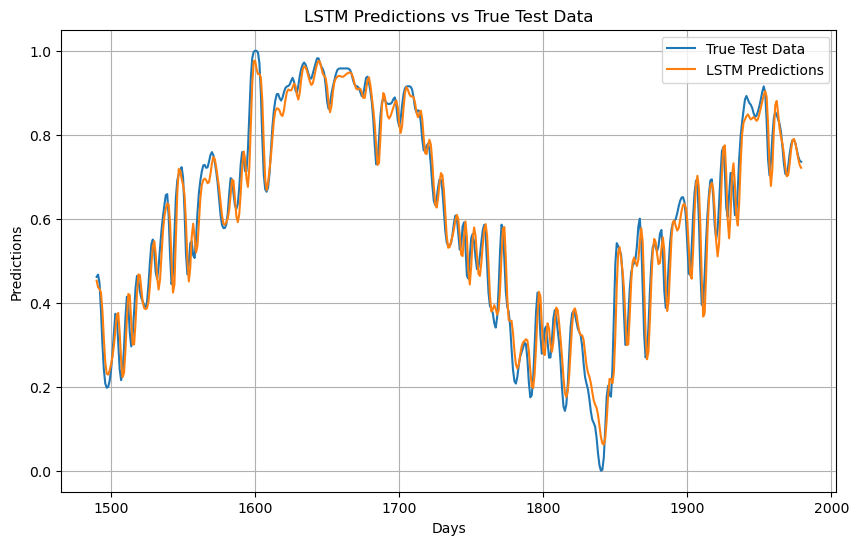

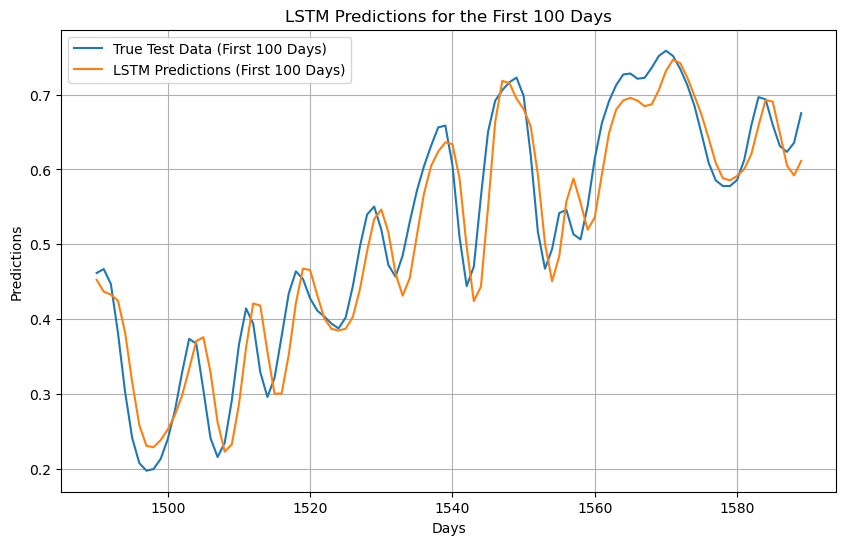

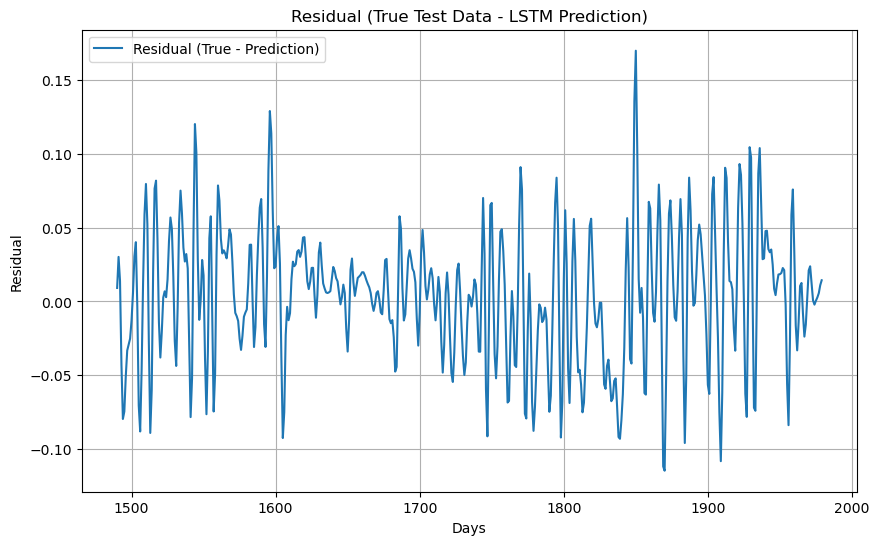

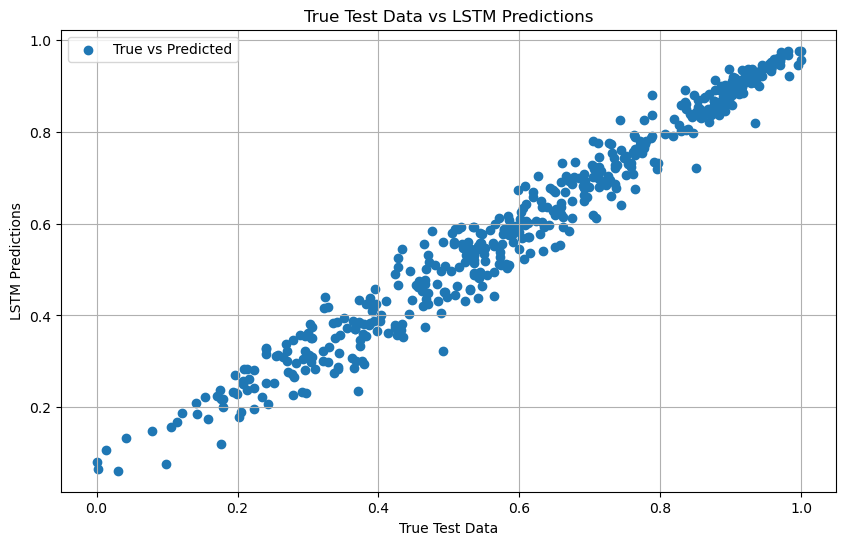

In [18]:
# 1. Training and test data vs days
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1490), train_labels, label="Training Data")
plt.plot(np.arange(1490, 1490 + 490), test_labels, label="Test Data")
plt.xlabel("Days")
plt.ylabel("Data")
plt.title("Training and Test Data vs Days")
plt.grid()
plt.legend()
plt.show()

# 2. LSTM predictions for the test data
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1490, 1490 + 490), test_labels, label="True Test Data")
plt.plot(np.arange(1490, 1490 + 490), test_predictions, label="LSTM Predictions")
plt.xlabel("Days")
plt.ylabel("Predictions")
plt.title("LSTM Predictions vs True Test Data")
plt.grid()
plt.legend()
plt.show()

# 3. LSTM predictions for the first 100 days
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1490, 1590), test_labels[:100], label="True Test Data (First 100 Days)")
plt.plot(np.arange(1490, 1590), test_predictions[:100], label="LSTM Predictions (First 100 Days)")
plt.xlabel("Days")
plt.ylabel("Predictions")
plt.title("LSTM Predictions for the First 100 Days")
plt.grid()
plt.legend()
plt.show()

# 4. Residual (y_test - prediction)
residual = test_labels - test_predictions
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1490, 1490 + 490), residual, label="Residual (True - Prediction)")
plt.xlabel("Days")
plt.ylabel("Residual")
plt.title("Residual (True Test Data - LSTM Prediction)")
plt.grid()
plt.legend()
plt.show()

# 5. Scatter plot between true test data vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, test_predictions, label="True vs Predicted")
plt.xlabel("True Test Data")
plt.ylabel("LSTM Predictions")
plt.title("True Test Data vs LSTM Predictions")
plt.grid()
plt.legend()
plt.show()